# Noisy quantum metrology: multi-qubit

In [15]:
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import seaborn as sns
import ultraplot as uplt

from squint.circuit import Circuit
from squint.ops.base import SharedGate
from squint.ops.dv import Conditional, DiscreteVariableState, HGate, RZGate, XGate
from squint.ops.noise import BitFlipChannel
from squint.utils import partition_op

In [24]:
dim = 2
n = 5

circuit = Circuit()
for i in range(n):
    circuit.add(DiscreteVariableState(wires=(i,), n=(0,)))

circuit.add(HGate(wires=(0,)))
for i in range(n - 1):
    circuit.add(Conditional(gate=XGate, wires=(i, i + 1)))

circuit.add(
    SharedGate(op=RZGate(wires=(0,), phi=0.1 * jnp.pi), wires=tuple(range(1, n))),
    "phase",
)

for i in range(n):
    circuit.add(HGate(wires=(i,)))


circuit.add(
    SharedGate(op=BitFlipChannel(wires=(0,), p=0.2), wires=tuple(range(1, n))),
    # SharedGate(op=DepolarizingChannel(wires=(0,), p=0.2), wires=tuple(range(1, n))),
    "noise",
)

params, static = eqx.partition(circuit, eqx.is_inexact_array)
params_phase, params_noise = partition_op(params, "phase")
params = (params_phase, params_noise)
sim = circuit.compile(static, dim, params_phase, params_noise)

In [23]:
path = circuit.subscripts
print(path)

a,b,c,d,e,f,g,h,i,j,ak,bl,kcmo,ldnp,oeqs,pfrt,sguw,thvx,wiyA,xjzB,mC,nD,qE,rF,uG,vH,yI,zJ,AK,BL,CM,DN,EO,FP,GQ,HR,IS,JT,KU,LV,쏜MW,쏜NX,쏞OY,쏞PZ,쏠QÀ,쏠RÁ,쏢SÂ,쏢TÃ,쏤UÄ,쏤VÅ->WYÀÂÄXZÁÃÅ


In [52]:
# ps = jnp.linspace(0, 0.5, 50)
ps = jnp.logspace(-8, jnp.log10(0.01), 50)

params_noise = eqx.tree_at(lambda pytree: pytree.ops["noise"].op.p, params_noise, ps)
params_phase = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].op.phi, params_phase, jnp.ones_like(ps) * 0.01
)

cfims = jax.vmap(sim.probabilities.cfim)(params_phase, params_noise)

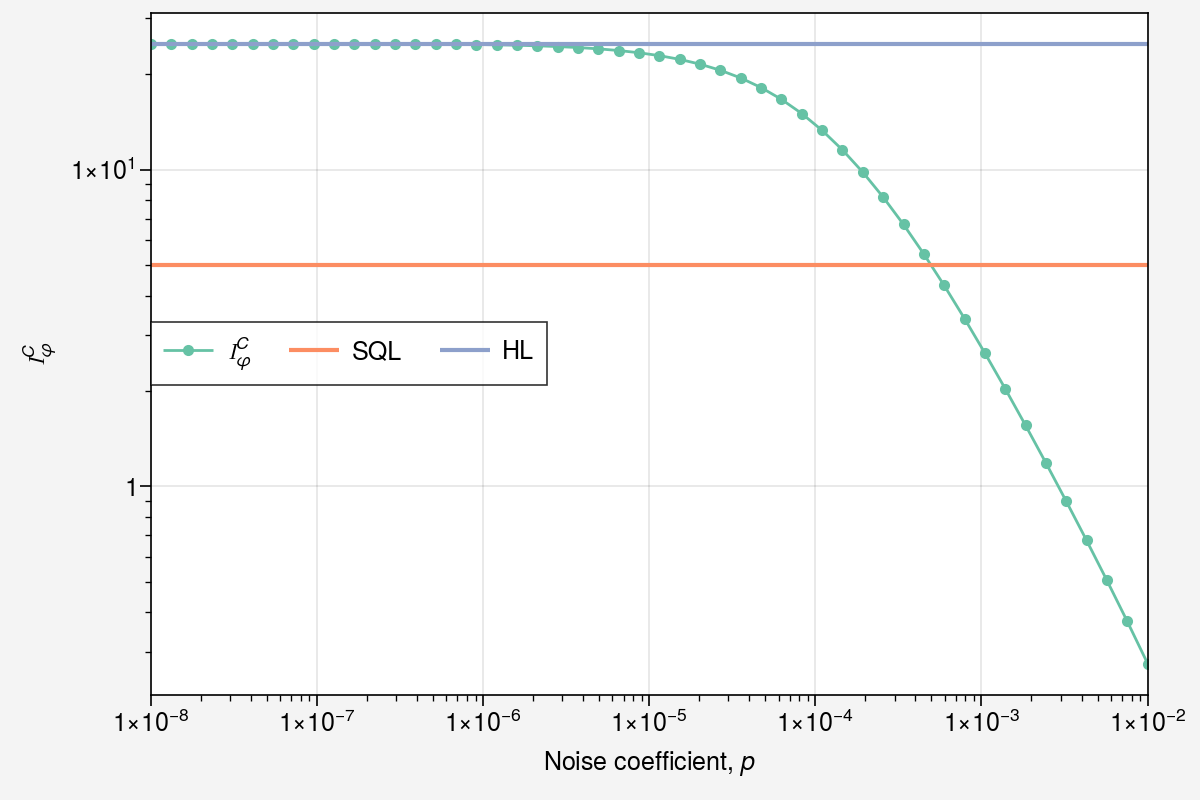

In [55]:
colors = itertools.cycle(sns.color_palette("Set2", n_colors=3))
fig, ax = uplt.subplots(nrows=1, figsize=(6, 4), sharey=False)

ax.plot(
    ps,
    cfims,
    color=next(colors),
    label=r"$\mathcal{I}_\varphi^C$",
    marker="o",
    markersize=3,
    linewidth=1,
)

ax.axhline(n, label="SQL", color=next(colors))
ax.axhline(n**2, label="HL", color=next(colors))
ax.set(
    xlabel=r"Noise coefficient, $p$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    # ylim=[0, 1.05 * jnp.max(cfims)],
    yscale="log",
    xscale="log",
)
ax.format(xformatter="sci", yformatter="sci")
ax.legend();